In [1]:
import torch
from torch import nn

import torchvision
from torchvision.transforms import v2, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.models as models

from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

## Dataset Loading and preprocessing

In [60]:
import os

img_path = "KITTI road dataset image path"
mask_path = "KITTI road dataset label path"

In [4]:
def load_images(path, mask=False):
    result = []
    images = os.listdir(path)
    if mask==True:
        images = [img for img in images if "road" in img]  # because there are no lane labels for all the training images

    images = sorted(images)

    for image in images:
        im = Image.open(os.path.join(path, image))
        im = im.resize((224, 224))
        res = np.asarray(im)
        result.append(res)

    return np.array(result)

In [5]:
def show_images(images, num_images_to_show):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = images[i-1,:]
        plt.imshow(img)

In [6]:
data = load_images(img_path, mask=False)
true_mask = load_images(mask_path, mask=True)

In [7]:
true_mask.shape

(289, 224, 224, 3)

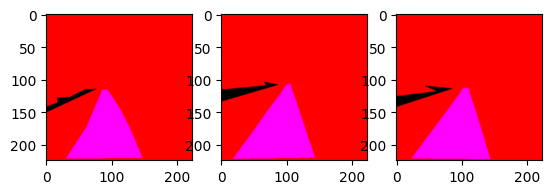

In [8]:
show_images(true_mask, 3)

In [9]:
# converting the mask labels into binary: road or not road
def binary_mask(true_mask):
    no_mask = len(true_mask)
    for i in range(no_mask):
        road_label = np.array([255, 0, 255])
        cond = np.all(true_mask[i] == road_label, axis=2)
        true_mask[i] = true_mask[i]*cond[..., np.newaxis]

In [10]:
binary_mask(true_mask)

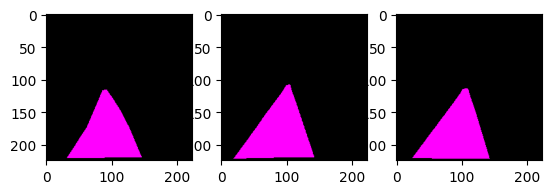

In [11]:
show_images(true_mask, 3)

In [12]:
# conversion to gray scale(for binary classification)
true_mask = np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask = np.expand_dims(true_mask, axis=-1)

In [13]:
# converting it to binary. background: 0, foreground: 1
true_mask[true_mask != 0.0] = 1.0

data = data/255.0

In [14]:
import albumentations as A
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5,border_mode=cv2.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])


In [55]:
# write the transformation for the data
# This transformation takes more time than augmentation pipeline, so I didn't use it.
apply_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAdjustSharpness(p=0.4, sharpness_factor=1.5),
    v2.RandomAutocontrast(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.ToTensor()
])

In [16]:
data = data.astype(np.float32)
true_mask = true_mask.astype(np.float32)

In [17]:
# Data augmentation is importatant for better training since dataset is quite small(tried without and results were not great)


# You can skip this also. It works without augmentation(tested it). Just run apply_transformation and use that on train_dataset below. But for better results it is advise to use augmentation pipeline
NewIMGS=10
for i in range(len(data)):
    for j in range(NewIMGS):
        image = data[i]
        mask = true_mask[i]
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        image_augmented = augmented['image']
        mask_augmented = augmented['mask']
        data = np.vstack((data, image_augmented[np.newaxis,...]))
        true_mask = np.vstack((true_mask, mask_augmented[np.newaxis,...]))

In [18]:
data.shape, true_mask.shape

((3179, 224, 224, 3), (3179, 224, 224, 1))

In [54]:
# Saving the augumented data and mask so data can be load and use without using the Augmentation pipeline again and again(time wasting)

np.savez('augumented_data', data)
np.savez('augumented_true_mask', true_mask)

# data = np.load('augmented_data.npy')
# true = np.load('augmented_true_mask.npy')

In [19]:
train_set_size = int(len(data)*0.8)

In [20]:
shuffled_indices = np.random.permutation(len(data))

shuffled_data = data[shuffled_indices]
shuffled_mask = true_mask[shuffled_indices]

In [21]:
x_train = shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
y_train = shuffled_mask[:train_set_size].transpose((0, 3, 1, 2))
print(f'train set size {x_train.shape}')

x_test = shuffled_data[train_set_size:].transpose((0, 3, 1, 2))
y_test = shuffled_mask[train_set_size:].transpose((0, 3, 1, 2))
print(f'test set size {x_test.shape}')

train set size (2543, 3, 224, 224)
test set size (636, 3, 224, 224)


In [22]:
print("Data shapes:")
print(f"shuffled_data shape: {shuffled_data.shape}")
print(f"shuffled_mask shape: {shuffled_mask.shape}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

Data shapes:
shuffled_data shape: (3179, 224, 224, 3)
shuffled_mask shape: (3179, 224, 224, 1)
x_train shape: (2543, 3, 224, 224)
y_train shape: (2543, 1, 224, 224)


## Creating Dataloader

In [23]:
# loading the dataset into pytorch dataset
class RoadDataset(Dataset):
    def __init__(self, imgs, mask, transform = None):
        self.imgs = imgs
        self.mask = mask
        self.transform = transform

    def __len__(self):
        return len(self.imgs)
    
    def get_batch_imgs(self, idx):
        return self.imgs[idx]
    
    def get_batch_mask(self, idx):
        return self.mask[idx]
    
    def __getitem__(self, index):
        imgs = self.get_batch_imgs(index)
        masks = self.get_batch_mask(index)
        if self.transform:
            imgs = self.transform(imgs)

        return imgs, masks

In [24]:
train_dataset = RoadDataset(x_train, y_train)
test_dataset = RoadDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4,shuffle=True)

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Create Model

In [ ]:
vgg16 = models.vgg16(pretrained=True)

plan is to only include the features layer of vgg16. and then add two module using the nn. sequentinal in the net. 
first module will convert all linear layers to the FCN and 2nd module will be for decoder which will map image to the original size. and decoder followed by a bilinear interpolation.

In [28]:
class FCN8(nn.Module):
    def __init__(self, num_classes):
        super(FCN8, self).__init__()

        features = list(vgg16.features.children())
        self.encoder = nn.Sequential(*features[:31])

        # converting the classifier layers of vgg16 into FC layers
        self.fc_layers = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Conv2d(in_channels=4096, out_channels=num_classes, kernel_size=1)
        )


        # Upsampling for decoder
        # formula used for calculating kernel size: 
        self.upsample1 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample2 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample3 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=16, stride=8, padding=4, bias=False)

        self.skip_connection3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.skip_connection4 = nn.Conv2d(512, num_classes, kernel_size=1)


    def forward(self, x):
        pool3 = self.encoder[:17](x)
        pool4 = self.encoder[17:24](pool3)
        pool5 = self.encoder[24:](pool4)

        output1 = self.fc_layers(pool5)   # this is fcn-32: use return output1

        score1 = self.upsample1(output1)

        # creating skip connection between upsample output of fc layers and pool4
        skip4 = self.skip_connection4(pool4)
        score2 = score1 + skip4


        score3 = self.upsample2(score2)   # this is fcn-16: use return score3

        # creating skip connection between upsample output of score3 and pool3
        skip3 = self.skip_connection3(pool3)
        score4 = score3 + skip3

        out = self.upsample3(score4)

        # Crop to match input size exactly
        h, w = x.size()[2:]
        h_pad = (out.size()[2] - h) // 2
        w_pad = (out.size()[3] - w) // 2
        out = out[:, :, h_pad:h_pad + h, w_pad:w_pad + w]

        return out

In [29]:
model = FCN8(num_classes=1).to(device)

In [30]:
optimizer = Adam(model.parameters(), lr=0.001)

## Loss function: Dice loss + BCE

In [31]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
    
    def forward(self, inputs, targets):
        return self.weight_bce * self.bce(inputs, targets) + self.weight_dice * self.dice(inputs, targets)

criterion = BCEDiceLoss()

In [32]:
from torch.nn import functional as F

In [33]:
def train_step(model, data_loader, optimizer, criterion):
    model = model.train()
    train_loss = []

    for x, y in data_loader:

        x = x.to(device)
        y = y.to(device)
        y_pred = model(x.float())

        loss = criterion(y_pred.float(), y.float())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())

    return np.mean(train_loss)    


# This is a validation step basically. Use this if validation set is created
def test_step(model, data_loader, criterion):
    validaion_loss = []
    model.eval()
    with torch.inference_mode():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x.float())

            loss = criterion(y_pred.float(), y.float())
            test_step.append(loss.item())

    return np.mean(validaion_loss)

In [34]:
torch.cuda.empty_cache()  # in case, you get the Out of Memory error. 

In [35]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 525374 KiB | 525374 KiB | 525374 KiB |      0 B   |\n|       from large pool | 524288 KiB | 524288 KiB | 524288 KiB |      0 B   |\n|       from small pool |   1086 KiB |   1086 KiB |   1086 KiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         | 525374 KiB | 525374 KiB | 525374 KiB |      0 B   |\n|       from large pool | 524288 KiB | 524288 KiB |

In [36]:
import math
loss = math.inf

loss_train = []
loss_validation = []

## Training time

In [ ]:
epochs = 50
for epoch in range(epochs):
    train_loss = train_step(model=model,
              data_loader=train_dataloader,
              optimizer=optimizer,criterion=criterion)
    
    # test_loss = test_step(model=model,
    #           data_loader=test_dataloader, criterion=criterion)
    
    if epoch%10 == 0 :
        print(f'Epoch {epoch + 1}/{epochs}')
        print('--'*10)
        print(f'Train loss: {train_loss}')
        # print(f'Test loss: {test_loss}')

    if train_loss < loss:
        torch.save(model.state_dict(), 'best_model.pth')
        loss = train_loss

    loss_train.append(train_loss)
    # loss_test.append(test_loss)


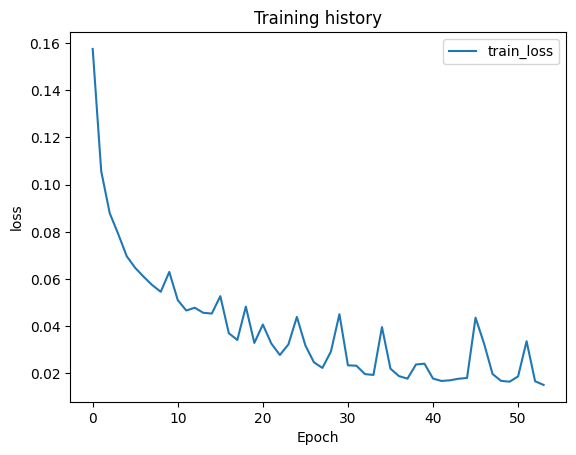

In [40]:
plt.plot(loss_train, label='train_loss')
# plt.plot(loss_test, label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()

In [41]:
model.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_5068/1559688700.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [45]:

prediction=model(torch.tensor(x_test[5][np.newaxis,...],device=device)).cpu().detach().numpy()

In [62]:
# Without this threshold, predicted mask will be blurry.

threshold = 0.5
predicted_mask_binary = (prediction > threshold).astype(int)

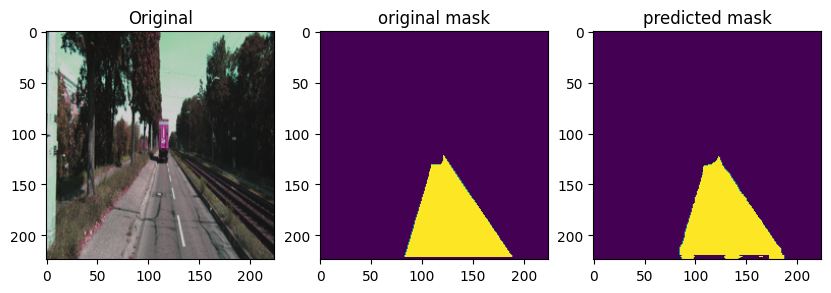

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(x_test[5].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[5].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_mask_binary[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

In [47]:
def predicted_mask(model, data_loader, criterion):
    mask = []
    test_loss = []
    model.eval()
    with torch.inference_mode():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x.float())

            mask.append(y_pred.cpu().detach().numpy())

            loss = criterion(y_pred.float(), y.float())
            test_loss.append(loss.item())

    return np.mean(test_loss), mask

In [48]:
loss,masks=predicted_mask(model=model,data_loader=test_dataloader,criterion=criterion)

In [49]:
loss

np.float64(0.03214723654325653)

In [68]:
get_predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    get_predicted_masks=np.vstack((get_predicted_masks, masks[idx]))
    get_predicted_masks = (get_predicted_masks > threshold).astype(int)

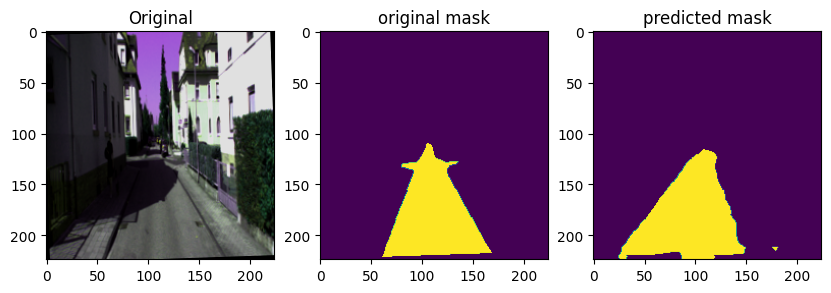

: 

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(x_test[2].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[2].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(get_predicted_masks[2].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()


## Use this on video

In [ ]:
# thanks claude for helping with this ;)

def process_frame(frame, model, device, img_size=(224, 224)):
    """Process a single frame through the FCN8 model"""
    # Resize frame
    frame_resized = cv2.resize(frame, img_size)
    
    # Convert to torch tensor and normalize
    x = torch.from_numpy(frame_resized).float()
    x = x.permute(2, 0, 1).unsqueeze(0)  # [1, C, H, W]
    x = x.to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        pred = model(x)
        pred = torch.sigmoid(pred)  # Apply sigmoid for binary segmentation
        mask = (pred > 0.5).float()  # Threshold at 0.5
    
    # Convert mask to numpy
    mask = mask[0, 0].cpu().numpy()  # Take first image and channel
    
    # Create RGB mask
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    mask_rgb[mask > 0] = [255, 0, 0]  # Red color for segmentation
    
    # Resize mask back to frame size
    mask_rgb = cv2.resize(mask_rgb, (frame.shape[1], frame.shape[0]))
    
    # Blend original frame with mask
    alpha = 0.5
    output = cv2.addWeighted(frame, 1, mask_rgb, alpha, 0)
    
    return output

def process_video(input_path, output_path, model, device, fps=10):
    """Process entire video with FCN8 model"""
    # Open video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Process frame
        processed_frame = process_frame(frame, model, device)
        
        # Write frame
        out.write(processed_frame)
        
        # Print progress
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processed {frame_count}/{total_frames} frames")
    
    cap.release()
    out.release()

def main():
    # Load your trained model
    model = FCN8(num_classes=1).to(device)
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    input_video = "path_for_input_video/video.mp4"
    output_video = "path_for_output_video/out_video.mp4"
    
    process_video(input_video, output_video, model, device)

if __name__ == "__main__":
    main()